## In this notebook, we study the a mixture Gaussian model
  1. In a first part, we look at what happen when we use an annealing procedure to adjust the variance
  2. In the second part, we now use the version where the variance is dynamically adjusted and look at the likelihood to have an hint about the best model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The next cells generate many clusters in two-dimensions in a random way

In [5]:
# Generate clusters
np.random.seed(4)
D = 2 # dim of the data
M = 200 # number of data
L = 10 # taille du cube
Nc = 5 # nb de clusters
σClus = 0.8

centers = np.array([])
for c in range(Nc):
    m = np.random.uniform(2*L,size=(D))-L
    centers = np.append(centers,[m])
    
centers = centers.reshape(Nc,D)
ch = [c for c in range(Nc)]
data_lab = np.random.choice(ch,size=(M))
data = np.zeros((D,M))
for i in range(Nc):
    idx = np.where(data_lab==i)
    data[:,idx[0]] = centers[i].reshape(D,1) + σClus*np.random.normal(size=(D,len(idx[0])))



In [6]:
data = data - np.mean(data,1).reshape(2,1)
centers = centers - np.mean(centers,0).reshape(1,2)

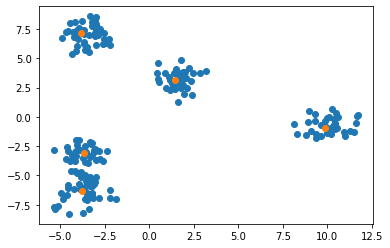

In [7]:
plt.scatter(data[0,:],data[1,:])
plt.scatter(centers[:,0],centers[:,1])

We now define the various function that we will use to 
  1. Adjust the means at each iteration
  2. Compute the responsability -> the probability that a datapoint is assigned to a given cluster
  3. The log-likelihood annd other interesting quantities

In [8]:
def initMeans(K,L,D):
    μ  = np.array([])
    for c in range(K):
        m = np.random.uniform(2*L,size=(D))-L
        μ = np.append(μ,[m])
    μ = μ.reshape(D,K)
    return μ

In [9]:
def ComputeResp(β,μ,X):
    # print(X.shape)
    Resp = np.zeros((X.shape[1],μ.shape[1]))
    for i in range(X.shape[1]):
        for c in range(μ.shape[1]):
            Resp[i,c] = np.exp(-β*np.linalg.norm(X[:,i] - μ[:,c])**2)
        Resp[i,:] = Resp[i,:] / np.sum(Resp[i,:])
    return Resp    
    
μ = initMeans(3,L,2)
P = ComputeResp(1,μ,data)

In [10]:
def MoveMean(X,μ,P):
    Λ = 1/np.sum(P,0)
    return np.matmul(np.matmul(X,P),np.diag(Λ))

In [11]:
def ComputeLike(β,X,μ):
    F = 0
    for i in range(X.shape[1]):
        tmp = 0
        for c in range(μ.shape[1]):
            tmp += np.exp(-β*np.linalg.norm(X[:,i] - μ[:,c])**2)
        F += np.log(tmp)
    return F/X.shape[1]

def ComputeEner(X,P,μ,K):
    E = np.zeros((K,X.shape[1]))
    for i in range(X.shape[1]):
        for c in range(K):
            E[c,i] = np.linalg.norm(X[:,i] - μ[:,c])**2
    return np.sum(np.diag(np.matmul(P,E)))/X.shape[1]

In [12]:
def ComputeProba(β,X,μ):
    EffK = μ.shape[1]
    pr_k = 1.0/EffK
    pref = pr_k/(2*np.pi)*β*0.5
    tmp = np.zeros(X.shape[1])
    for c in range(EffK):
        for i in range(X.shape[1]):
            tmp[i] += np.exp(-β*np.linalg.norm(X[:,i] - μ[:,c])**2)
    tmp = tmp*pref
    return tmp

We recall that the first threhold is given by the higest eigenvalue of the dataset

In [14]:
autov = 1/(2*np.linalg.eigvals(np.cov(data)))
print(r"Threshold for $\beta$=",np.min(autov))

Threshold for $\beta$= 0.017108190697307166


Now we can define the following cell, starting from high variance (low-beta) and gradually decrease it.

<ipython-input-18-931a7afe32aa>:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(μ[0,:],μ[1,:],s=100, c=colors_t[i])


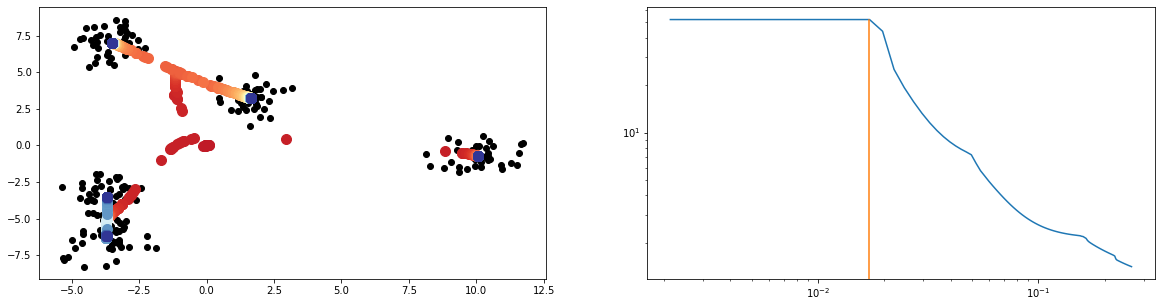

In [18]:
K=15 # number of clusters 
βI = np.min(autov)/2
μ = initMeans(K,L,D) # position of the mean
f,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(data[0,:],data[1,:],color='black')

Ener = np.array([])
FEner = np.array([])
Allβ = np.array([])
Lβ = np.arange(βI/4,σClus/3,0.0025)
Ncol = Lβ.shape[0]
# for β in np.arange(0.005,0.2,0.005):
colors_t=plt.cm.RdYlBu(np.linspace(0,1,Ncol))
for i,β in enumerate(Lβ):
    μ = μ + 0.1*np.random.normal(size=(μ.shape))
    for it in range(20):
        # pp.scatter(μ[0,:],μ[1,:],s=100)
        P = ComputeResp(β,μ,data)
        μ = MoveMean(data,μ,P)

    ax[0].scatter(μ[0,:],μ[1,:],s=100, c=colors_t[i])
    Ener = np.append(Ener,ComputeEner(data,P,μ,K))
    FEner = np.append(FEner,ComputeLike(β,data,μ)/β)
    Allβ = np.append(Allβ,β)
    
    
    
    
ax[1].loglog(Allβ,Ener)
ax[1].plot([np.min(autov),np.min(autov)],[0,Ener[0]])

In [19]:
# Post-Analysis
idx = np.where(data[0,:]<5.0)
autov_ = 1/(2*np.linalg.eigvals(np.cov(data[:,idx[0]] - np.mean(data[:,idx[0]],1).reshape(2,1))))
idx1 = np.where(data[1,idx[0]]>0)
autov_1 = 1/(2*np.linalg.eigvals(np.cov(data[:,idx[0]][:,idx1[0]] - np.mean(data[:,idx[0]][:,idx1[0]],1).reshape(2,1))))
idx2 = np.where(data[1,idx[0]]<0)
autov_2 = 1/(2*np.linalg.eigvals(np.cov(data[:,idx[0]][:,idx2[0]] - np.mean(data[:,idx[0]][:,idx2[0]],1).reshape(2,1))))

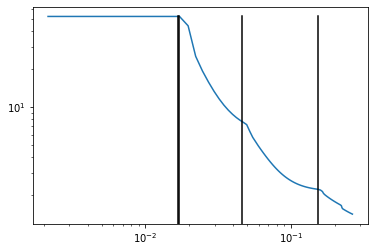

In [20]:
plt.loglog(Allβ,Ener)
plt.plot([np.min(autov),np.min(autov)],[0,Ener[0]],color='black')
plt.plot([np.min(autov_),np.min(autov_)],[0,Ener[0]],color='black')
plt.plot([np.min(autov_1),np.min(autov_1)],[0,Ener[0]],color='black')
plt.plot([np.min(autov_2),np.min(autov_2)],[0,Ener[0]],color='black')

We check the position of the centers w.r.t. the true ones

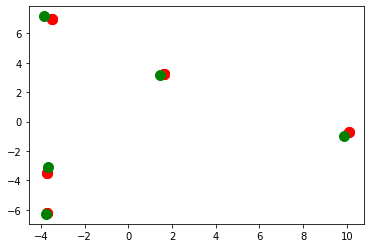

In [21]:
plt.scatter(μ[0,:],μ[1,:],s=100, c='red')
plt.scatter(centers[:,0],centers[:,1],s=100, c='green')

## TODO:
  1. to program a function fo adjusting dynamically the variance
  2. the functions ComputeRest and ComputeLike to include the variance in the function

In [386]:
def ComputeRespSig(σ,μ,X):
    # TODO
    return Resp    


In [387]:
def ComputeLikeSig(σ,X,μ):
    F = 0
    # TODO
    return F/X.shape[1]


In [388]:
def AdjustVar(X,μ,P,ϵ=0.01):
    σ = np.zeros(μ.shape[1])
    # TODO
    return σ

## Using the likelihood to choose the best solution

Given the strong fluctuation between two different initialization, we need to many many restarts to choose the best solution.
## TODO:
  1. run the algorithm for many different values of $K$ and choose the best model for each
  2. plot the best likelihood as a function of $K$

In [ ]:
# TODO ...